# **CS 131 Final Project: *Parks and Recreation* Character Classification**

In this notebook, the end goal is to be able to classify characters given a clip from the hit comedy television show, *Parks and Recreation*. I split this project into three parts:
- Data processing (labeling and custom dataset set up) and training model from HW7
- Video processing to get bets frame to input into the model
- Combine video processing and classification model together

Note: I only used a subset of the characters as getting and hand-labeling data is time-consuming and difficult. Additionally, I had to emulate a facial bounding box thus all of the training images for the first part are close up crops of the characters!

### Part 1: Data Processing and Basic Model Training

After downloading images from Google of different characters (by themselves, not with other characters in the image), I had to label each by hand in a CSV file. Then, I created a custom dataset class called `ParksAndRecDataset` which processes the image data and labels into a PyTorch friendly dataset.

In [1]:
%load_ext autoreload
%autoreload 2

#### Import PyTorch and dataset information

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from ParksAndRecDataset import ParksAndRecDataset
import torch.optim as optim
import torch.nn as nn

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

#### Load data and show image example

In [112]:
trainloader = None
testloader = None
batch_size = 1

norm_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# split datasets
parks_and_rec_dataset = ParksAndRecDataset(csv_file='./pnr_data/images/pnr_image_classification.csv',
                                    root_dir='./pnr_data/images/', transform = norm_transform)

# randomly separate data into 2/3 for training and 1/3 for testing
train_size = int((len(parks_and_rec_dataset) - 1) * 0.67)
test_size = len(parks_and_rec_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(parks_and_rec_dataset, [train_size, test_size])

# load the training dataset into a loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

# these are the different characters
classes = ('leslie', 'ben', 'ron', 'donna', 'april')

Feature batch shape: torch.Size([1, 3, 128, 128])
Labels batch shape: torch.Size([1])


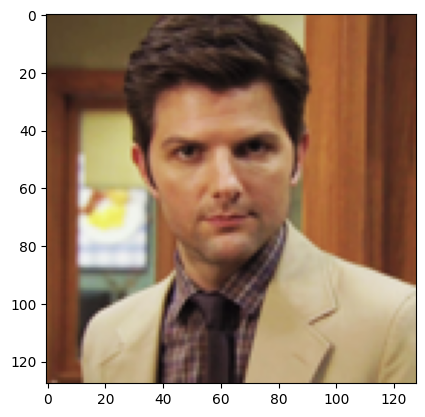

Label: ben


In [137]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
imshow(img)
print(f"Label: {classes[label]}")

#### Define basic neural network (same from HW7, after tuning and improvements)

I utilized my model from HW7 as well as some improvements like adding dropout and changing the optimizer and loss below!

In [114]:
# basic network
# Network Architecture - Batch Norm
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_fn = nn.ReLU()
        self.kernel_size = 3
        self.padding = 1
        
        # set up 2d convolutions
        self.conv_1 = nn.Conv2d(3, 64, self.kernel_size, 1, self.padding)
        self.norm_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d(2, 2)
        
        self.conv_2 = nn.Conv2d(64, 128, self.kernel_size, 1, self.padding)
        self.norm_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d(2, 2)
        
        self.conv_3 = nn.Conv2d(128, 128, self.kernel_size, 1, self.padding)
        self.norm_3 = nn.BatchNorm2d(128)
        self.pool_3 = nn.MaxPool2d(2, 2)
        
        self.conv_4 = nn.Conv2d(128, 128, self.kernel_size, 1, self.padding)
        self.norm_4 = nn.BatchNorm2d(128)
        self.pool_4 = nn.MaxPool2d(2, 2)
        
        # set up fully connected layer
        self.num_lin_inputs = 512 * 4 * 4
        self.fc_1 = nn.Linear(self.num_lin_inputs, 5)
        
        # add dropout
        self.dropout = nn.Dropout(0.4)
        
        ### END YOUR CODE

    def forward(self, x):
        ### YOUR CODE HERE
        
        # apply activation func to conv layers
        layer_1 = self.act_fn(self.norm_1(self.conv_1(x)))
        pooled_layer_1 = self.pool_1(layer_1) 
        
        layer_2 = self.act_fn(self.norm_2(self.conv_2(pooled_layer_1)))
        pooled_layer_2 = self.pool_2(layer_2)
        
        layer_3 = self.act_fn(self.norm_3(self.conv_3(pooled_layer_2)))
        pooled_layer_3 = self.pool_3(layer_3)
        
        layer_4 = self.act_fn(self.norm_4(self.conv_4(pooled_layer_3)))
        pooled_layer_4 = self.pool_4(layer_4)
        
        # reshape using view()
        reshaped = pooled_layer_4.view(-1, self.num_lin_inputs)
        
        # input into fully connected layers
        dropped = self.dropout(reshaped)
        x = self.fc_1(dropped)
        
        ### END YOUR CODE
        return x

#### Train the basic model

In [115]:
net = Net()

criterion = nn.CrossEntropyLoss()

# optimizer is AdamW
optimizer = optim.AdamW(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [116]:
epoch_num = 25
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if (epoch + 1) % 5 == 0 and (i + 1) % 10 == 0: 
            print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss))
        running_loss = 0.0
        
    scheduler.step()

print('Finished Training')

[5,    10] loss: 0.003
[5,    20] loss: 0.025
[5,    30] loss: 0.061
[5,    40] loss: 0.002
[5,    50] loss: 0.007
[10,    10] loss: 0.002
[10,    20] loss: 0.005
[10,    30] loss: 0.001
[10,    40] loss: 0.002
[10,    50] loss: 0.000
[15,    10] loss: 0.000
[15,    20] loss: 0.004
[15,    30] loss: 0.007
[15,    40] loss: 0.015
[15,    50] loss: 0.006
[20,    10] loss: 0.001
[20,    20] loss: 0.000
[20,    30] loss: 0.001
[20,    40] loss: 0.001
[20,    50] loss: 0.001
[25,    10] loss: 0.001
[25,    20] loss: 0.003
[25,    30] loss: 0.002
[25,    40] loss: 0.000
[25,    50] loss: 0.001
Finished Training


#### Ensure the model achieves high accuracy on training images

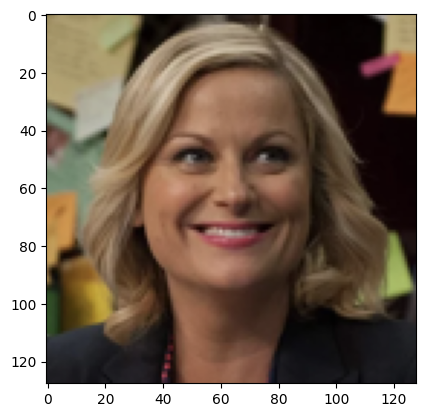

real: leslie
predicted: leslie


In [117]:
train_features, train_labels = next(iter(trainloader))
model_output = net.forward(train_features)
predicted = torch.max(model_output, 1)[1]

img = train_features[0].squeeze()
imshow(img)

# check groundtruth
for p in range(len(predicted)):
    print("real: " + classes[train_labels[p]])
    print("predicted: " +  classes[predicted[p]])

In [118]:
# test all train images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        model_output = net.forward(images)
        predicted = torch.max(model_output, 1)[1]
        
        for i, curr_label in enumerate(labels):
            curr = predicted[i]
            if curr == curr_label:
                correct += 1
            total += 1

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 100 %


#### Utilize testing data in checking accuracy of model

In [134]:
# prepare to count predictions for each character
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# test all test images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        model_output = net.forward(images)
        predicted = torch.max(model_output, 1)[1]
        
        for i, curr_label in enumerate(labels):
            curr = predicted[i]
            curr_class = classes[curr_label]
            
            if curr == curr_label:
                correct += 1
                correct_pred[curr_class] += 1
            total += 1
            total_pred[curr_class] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

print("")

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for character {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the test images: 80 %

Accuracy for character leslie is: 100.0 %
Accuracy for character ben   is: 66.7 %
Accuracy for character ron   is: 66.7 %
Accuracy for character donna is: 100.0 %
Accuracy for character april is: 80.0 %


**Performance:** Accuracy fluctuates between 69-80%

Now that we have finished training our model on some images of the characters we will use in our video portion, we can move on to actually utilizing TV show clips!

In [135]:
# saving model for future use
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

### Part 2: Video Processing

Using some of my code from HW5, we can identify the characters in short video clips from the show itself. The code uses the animated bbox from the utils file! In this section, I used [OpenCV](https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359) to read in my clipped video files and frames from the show.

In [2]:
# import open CV to read video files and get image frames from them
import cv2

# get the video from path
video_path = "./pnr_data/leslie_1.mp4"

In [3]:
# get video objects
video = cv2.VideoCapture(video_path)

# print fps
fps = video.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

frames per second = 25.0
